# Phase Estimation

## Input
1. An known unitary $U$ and its eigenstate $\vert\psi\rangle$ with $U\vert\psi\rangle=e^{2\pi i\theta}\vert\psi\rangle$

## Goal
1. Estimate $\theta$
2. Extensiblity:
    - can choose the number of qubit for the first register in order to accommodate to contrains in qubit available.
3. Error Assessment:
    - Submit the circuit to simulator and actual quantum computers several time to get distribution of the error.

## Cicuit Construction
### package

In [92]:
import numpy as np
from math import pi
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, BasicAer, execute, IBMQ
from qiskit.visualization import plot_bloch_multivector, plot_histogram

### Circuit 
#### Helper Functions

In [93]:
def pe_circ_init(size:int):
    #quantum register and  single state for storing eigen-state
    qr = QuantumRegister(size)
    psi = QuantumRegister(1,name="psi")
    #classical bits for readout
    cr = ClassicalRegister(size)
    
    qc = QuantumCircuit(qr,psi,cr)
    # apply Hadamards and init the eigenstate as |1>
    for i in range(size):
        qc.h(i)
    qc.x(size)
    
    qc.barrier()
    
    return qc

def C_U(circuit:QuantumCircuit, size:int, phi:float):
    
    rep = 1
    for counting_qubit in range(size):
        for i in range(rep):
            circuit.cu1(2*pi*phi, counting_qubit, size)
        rep *= 2
    
    circuit.barrier()
    
    return 

def qft_dagger(qc:QuantumCircuit,size:int):
    
    for qubit in range(size//2):
        qc.swap(qubit,size-qubit-1)
    for j in range(size):
        for m in range(j):
            qc.cu1(-pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.barrier()
    return

def readout(qc:QuantumCircuit,size:int):
    for i in range(size):
        qc.measure(i,i)
    return

#### circuit generator

In [94]:
def phaseEstCircuit(size:int, phi:float):
    qc = pe_circ_init(size)
    C_U(qc, size, phi)
    qft_dagger(qc, size)
    readout(qc,size)
    
    return qc

### Result Decoder

In [134]:
def counts_decode(counts):
    decoded = {}
    for key in counts:
        decimal_key = 0.0
        i = -1
        for c in key:
            b = int(c)
            if b:
                decimal_key += 2**i
            i -= 1
        decoded[decimal_key] = counts[key]
    return decoded

def expectation(decode_counts):
    res = 0.0
    total = 0
    for key in decode_counts:
        total += decode_counts[key]
        res += key*decode_counts[key]
    return res/total

def choosemax(decode_counts):
    counts = 0
    result = 0.0
    for key in decode_counts:
        if decode_counts[key] > counts:
            counts = decode_counts[key]
            result = key
    return  result

In [135]:
def getEstPhi(PhaseEstQC:QuantumCircuit, back_end, shots, metric):
    # get backend
    result = execute(qc,backend=back_end,shots=shots).result()
    counts = result.get_counts()
    plot_histogram(counts)

    dt = counts_decode(counts)
    est_val = metric(dt)

    return est_val

## Parameter Initialize

### Fixed Parameter

In [136]:
qubit = 4
nTrail = 20
back_end = BasicAer.get_backend("qasm_simulator")
shots = 4096

### Random Parameter

In [119]:
Phi = np.random.random((nTrail,))

## Start Trail
###

In [167]:
Phi_est = []
for phi in Phi:
    qc = phaseEstCircuit(qubit, phi)
    single_run_res = getEstPhi(qc, back_end,shots,metric=choosemax)
    Phi_est.append(single_run_res)
Phi_est = np.array(Phi_est)

In [168]:
error = np.abs(Phi_est-Phi)/Phi

In [169]:
print(Phi)
print(Phi_est)
print(error)

[0.08472903 0.49427404 0.3674613  0.23268809 0.26036368 0.1725342
 0.83520491 0.02854865 0.29719056 0.15837361 0.93240718 0.89152515
 0.98992309 0.95712292 0.09845416 0.68571242 0.67088983 0.13470467
 0.28937305 0.37873211]
[0.078125 0.5      0.375    0.234375 0.265625 0.171875 0.828125 0.03125
 0.296875 0.15625  0.9375   0.890625 0.984375 0.953125 0.09375  0.6875
 0.671875 0.140625 0.296875 0.375   ]
[0.07794295 0.01158459 0.02051562 0.00724965 0.02020759 0.00382068
 0.00847686 0.09462273 0.0010618  0.01340886 0.00546201 0.00100968
 0.00560457 0.00417702 0.04778019 0.0026069  0.00146845 0.04395044
 0.02592482 0.00985422]


In [170]:
qubit = 5
nTrail = 20
back_end = BasicAer.get_backend("qasm_simulator")
shots = 4096

Phi_est = []
for phi in Phi:
    qc = phaseEstCircuit(qubit, phi)
    single_run_res = getEstPhi(qc, back_end,shots,metric=choosemax)
    Phi_est.append(single_run_res)
Phi_est = np.array(Phi_est)

error = np.abs(Phi_est-Phi)/Phi
print(Phi)
print(Phi_est)
print(error)

[0.08472903 0.49427404 0.3674613  0.23268809 0.26036368 0.1725342
 0.83520491 0.02854865 0.29719056 0.15837361 0.93240718 0.89152515
 0.98992309 0.95712292 0.09845416 0.68571242 0.67088983 0.13470467
 0.28937305 0.37873211]
[0.09375 0.5     0.375   0.21875 0.25    0.1875  0.84375 0.03125 0.3125
 0.15625 0.9375  0.90625 0.      0.96875 0.09375 0.6875  0.65625 0.125
 0.28125 0.375  ]
[0.10646845 0.01158459 0.02051562 0.05990032 0.03980462 0.08674108
 0.01023113 0.09462273 0.05151389 0.01340886 0.00546201 0.01651647
 1.         0.01214795 0.04778019 0.0026069  0.02182152 0.07204405
 0.02807122 0.00985422]


In [171]:
qubit = 6
nTrail = 20
back_end = BasicAer.get_backend("qasm_simulator")
shots = 4096

Phi_est = []
for phi in Phi:
    qc = phaseEstCircuit(qubit, phi)
    single_run_res = getEstPhi(qc, back_end,shots,metric=choosemax)
    Phi_est.append(single_run_res)
Phi_est = np.array(Phi_est)

error = np.abs(Phi_est-Phi)/Phi
print(Phi)
print(Phi_est)
print(error)

[0.08472903 0.49427404 0.3674613  0.23268809 0.26036368 0.1725342
 0.83520491 0.02854865 0.29719056 0.15837361 0.93240718 0.89152515
 0.98992309 0.95712292 0.09845416 0.68571242 0.67088983 0.13470467
 0.28937305 0.37873211]
[0.078125 0.5      0.375    0.234375 0.265625 0.171875 0.828125 0.03125
 0.296875 0.15625  0.9375   0.890625 0.984375 0.953125 0.09375  0.6875
 0.671875 0.140625 0.296875 0.375   ]
[0.07794295 0.01158459 0.02051562 0.00724965 0.02020759 0.00382068
 0.00847686 0.09462273 0.0010618  0.01340886 0.00546201 0.00100968
 0.00560457 0.00417702 0.04778019 0.0026069  0.00146845 0.04395044
 0.02592482 0.00985422]


In [172]:
qubit = 7
nTrail = 20
back_end = BasicAer.get_backend("qasm_simulator")
shots = 4096

Phi_est = []
for phi in Phi:
    qc = phaseEstCircuit(qubit, phi)
    single_run_res = getEstPhi(qc, back_end,shots,metric=choosemax)
    Phi_est.append(single_run_res)
Phi_est = np.array(Phi_est)

error = np.abs(Phi_est-Phi)/Phi
print(Phi)
print(Phi_est)
print(error)

[0.08472903 0.49427404 0.3674613  0.23268809 0.26036368 0.1725342
 0.83520491 0.02854865 0.29719056 0.15837361 0.93240718 0.89152515
 0.98992309 0.95712292 0.09845416 0.68571242 0.67088983 0.13470467
 0.28937305 0.37873211]
[0.0859375 0.4921875 0.3671875 0.234375  0.2578125 0.171875  0.8359375
 0.03125   0.296875  0.15625   0.9296875 0.890625  0.9921875 0.9609375
 0.1015625 0.6875    0.671875  0.1328125 0.2890625 0.375    ]
[0.01426275 0.00422142 0.00074513 0.00724965 0.00979851 0.00382068
 0.00087713 0.09462273 0.0010618  0.01340886 0.00291684 0.00100968
 0.00228746 0.00398546 0.03157146 0.0026069  0.00146845 0.0140468
 0.0010732  0.00985422]


In [173]:
qubit = 8
nTrail = 20
back_end = BasicAer.get_backend("qasm_simulator")
shots = 4096

Phi_est = []
for phi in Phi:
    qc = phaseEstCircuit(qubit, phi)
    single_run_res = getEstPhi(qc, back_end,shots,metric=choosemax)
    Phi_est.append(single_run_res)
Phi_est = np.array(Phi_est)

error = np.abs(Phi_est-Phi)/Phi
print(Phi)
print(Phi_est)
print(error)

[0.08472903 0.49427404 0.3674613  0.23268809 0.26036368 0.1725342
 0.83520491 0.02854865 0.29719056 0.15837361 0.93240718 0.89152515
 0.98992309 0.95712292 0.09845416 0.68571242 0.67088983 0.13470467
 0.28937305 0.37873211]
[0.0859375  0.49609375 0.3671875  0.234375   0.26171875 0.171875
 0.8359375  0.02734375 0.296875   0.16015625 0.93359375 0.890625
 0.98828125 0.95703125 0.09765625 0.6875     0.671875   0.1328125
 0.2890625  0.37890625]
[1.42627502e-02 3.68158284e-03 7.45125398e-04 7.24965406e-03
 5.20453879e-03 3.82067945e-03 8.77134032e-04 4.22051074e-02
 1.06180076e-03 1.12559211e-02 1.27258562e-03 1.00967522e-03
 1.65855746e-03 9.57781569e-05 8.10436355e-03 2.60689669e-03
 1.46844679e-03 1.40468048e-02 1.07319921e-03 4.59796835e-04]


In [157]:
def get_error(size, Phi, back_end, shots, metric):
    Phi_est = []
    for phi in Phi:
        qc = phaseEstCircuit(qubit, phi)
        qc.draw()
        single_run_res = getEstPhi(qc, back_end,shots,metric)
        Phi_est.append(single_run_res)
    Phi_est = np.array(Phi_est)

    return np.abs(Phi_est-Phi)/Phi

In [158]:
error_4 = get_error(size=4, Phi=Phi, back_end=back_end,shots=2048,metric=choosemax)

In [142]:
error_5 = get_error(size=5, Phi=Phi, back_end=back_end,shots=2048,metric=choosemax)

In [143]:
error_6 = get_error(size=6, Phi=Phi, back_end=back_end,shots=2048,metric=choosemax)

In [144]:
import matplotlib.pyplot as plt

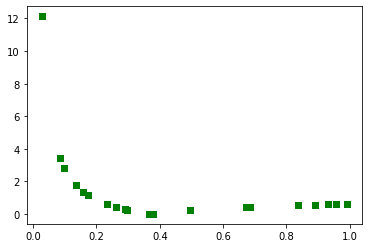

In [145]:
plt.plot(Phi,error_4,'rs',Phi,error_5,'bs',Phi,error_6,'gs')

In [159]:
error_4

array([3.42587382e+00, 2.41311559e-01, 2.05156166e-02, 6.11599446e-01,
       4.40293071e-01, 1.17348215e+00, 5.51008388e-01, 1.21354728e+01,
       2.61816673e-01, 1.36781874e+00, 5.97815196e-01, 5.79372495e-01,
       6.21182694e-01, 6.08200795e-01, 2.80887924e+00, 4.53123511e-01,
       4.41040867e-01, 1.78386785e+00, 2.95905039e-01, 9.85422169e-03])

In [147]:
error_5

array([3.42587382e+00, 2.41311559e-01, 2.05156166e-02, 6.11599446e-01,
       4.40293071e-01, 1.17348215e+00, 5.51008388e-01, 1.21354728e+01,
       2.61816673e-01, 1.36781874e+00, 5.97815196e-01, 5.79372495e-01,
       6.21182694e-01, 6.08200795e-01, 2.80887924e+00, 4.53123511e-01,
       4.41040867e-01, 1.78386785e+00, 2.95905039e-01, 9.85422169e-03])